In [1]:
# load std libs
from os import scandir
from datetime import datetime

# load third-party libraries
from tqdm import tqdm
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

# load source code
from src.image_loader import load_images
from src.utils import one_hot, shuffle_and_split, shuffle, get_batch
from src.alexnet import AlexNet

# initialization code
np.random.seed(42)
IMG_SIZE = 224

### EDA
Inspect the data a bit. Make sure you've downloaded the training data, unzipped it, and placed it in the `./data/train/raw` directory.

In [16]:
image_dimensions = !find ./data/train/raw -type f -name '*.png' -exec identify -format '%w %h\n' {} +

In [17]:
image_dims_df = pd.DataFrame((map(int, dims.split(' ')) for dims in image_dimensions), columns=("w", "h"))
image_dims_df["ratio"] = image_dims_df.apply(lambda row: row.w / row.h, axis=1)
display(image_dims_df.head())

,w,h,ratio
0,163,163,1.0
1,886,886,1.0
2,498,498,1.0
3,856,856,1.0
4,300,300,1.0


# of images: 4750 

                 w            h        ratio
count  4750.000000  4750.000000  4750.000000
mean    371.465895   370.730105     1.000364
std     323.275012   318.649607     0.009373
min      49.000000    49.000000     0.943368
25%     140.000000   140.000000     1.000000
50%     266.500000   266.500000     1.000000
75%     507.750000   507.000000     1.000000
max    3991.000000  3457.000000     1.332083


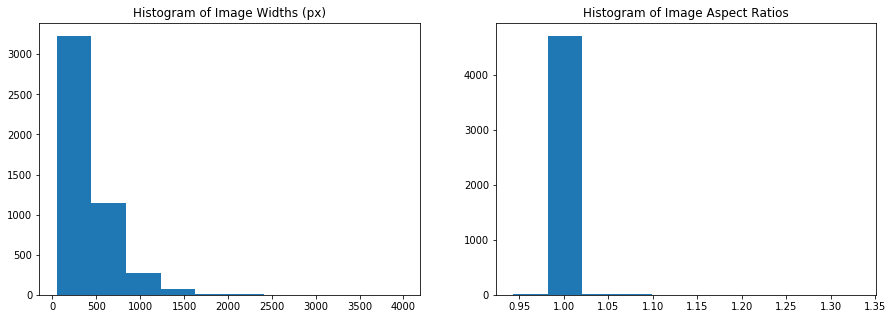

In [18]:
print("# of images: %d" % len(image_dims_df), "\n")

print(image_dims_df.describe())

fig = plt.figure(figsize=(15, 5))
sub1 = fig.add_subplot(1, 2, 1)
sub1.hist(image_dims_df.w)
sub1.set_title("Histogram of Image Widths (px)")
sub2 = fig.add_subplot(1, 2, 2)
sub2.hist(image_dims_df.ratio)
sub2.set_title("Histogram of Image Aspect Ratios")
None

### Resize images
Run this once to resize the images and save to disk. This takes a few minutes.

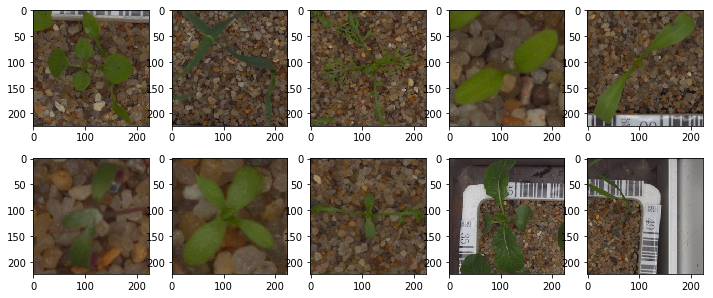

In [3]:
train_imgs = load_images("./data/train/raw/*/*.png",
                         desired_size=IMG_SIZE,
                         scale_down=True,
                         scale_up=True,
                         write_to="./data/train/resized",
                         preserve_dir_tree_at="./data/train/raw")

fig = plt.figure(figsize=(12, 5))
for i in range(10):
    sub = fig.add_subplot(2, 5, i + 1)
    rand_i = np.random.randint(0, len(train_imgs))
    sub.imshow(train_imgs[rand_i])

del train_imgs

In [2]:
class_names = [f.name for f in scandir("./data/train/raw") if f.is_dir()]
print(class_names)

class_name_to_idx = {}
class_idx_to_name = {}
train_imgs_ord = []
train_labels_ord = []

for i, name in enumerate(class_names):
    class_name_to_idx[name] = i
    class_idx_to_name[i] = name
    imgs = load_images("./data/train/resized/%s/*.png" % name)
    train_imgs_ord.extend(imgs)
    train_labels_ord.extend([i] * len(imgs))

train_imgs_ord = np.array(train_imgs_ord, dtype=np.float32)
print(train_imgs_ord.shape)
train_labels_ord = one_hot(train_labels_ord)
print(train_labels_ord.shape)

['Charlock', 'Common Chickweed', 'Loose Silky-bent', 'Black-grass', 'Cleavers', 'Small-flowered Cranesbill', 'Scentless Mayweed', 'Fat Hen', 'Common wheat', 'Shepherds Purse', 'Sugar beet', 'Maize']
(4750, 224, 224, 3)
(4750, 12)


In [3]:
train_data, train_labels, dev_data, dev_labels = shuffle_and_split(train_imgs_ord, train_labels_ord, dev_fraction=0.15)

print(train_data.shape)
print(train_labels.shape)
print(dev_data.shape)
print(dev_labels.shape)

(4038, 224, 224, 3)
(4038, 12)
(712, 224, 224, 3)
(712, 12)


In [4]:
batch_size = 128
num_classes = train_labels.shape[1]

tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(batch_size, IMG_SIZE, IMG_SIZE, 3), name="X")
Y = tf.placeholder(tf.float32, shape=(batch_size, num_classes), name="Y")
dropout = tf.placeholder(tf.float16, name="dropout_rate")
learn_rate = tf.placeholder(tf.float16, name="learning_rate")

model = AlexNet(X, dropout, num_classes)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model.logits, labels=Y))

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learn_rate)
    optimization_op = optimizer.minimize(loss)

tf.summary.scalar('loss', loss)

with tf.name_scope("accuracy"):
    predictions = tf.argmax(model.logits, axis=1)
    correct_predictions = tf.equal(predictions, tf.argmax(Y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

tf.summary.scalar('training_accuracy', accuracy)

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("./tensorboard")
saver = tf.train.Saver()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [5]:
def train_and_evaluate(train_data, train_labels, dev_data, dev_labels, learning_rate, num_epochs, dropout_rate=0.5, display_step=10):
    training_batches_per_epoch = int(np.floor(train_data.shape[0] / batch_size))
    dev_batches_per_epoch = int(np.floor(dev_data.shape[0] / batch_size))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer.add_graph(sess.graph)

        for epoch in range(num_epochs):
            print("{} epoch number: {}".format(datetime.now(), epoch + 1))
            train_data, train_labels = shuffle(train_data, train_labels)

            for step in range(training_batches_per_epoch):
                x_batch, y_batch = get_batch(train_data, train_labels, step, batch_size)
                sess.run(optimization_op, feed_dict={X: x_batch, Y: y_batch, dropout: dropout_rate, learn_rate: learning_rate })

                # every so often, report the progress of our loss and training accuracy
                if step % display_step == 0:
                    summ = sess.run(merged_summary, feed_dict={X: x_batch, Y: y_batch, dropout: 0 })
                    writer.add_summary(summ, epoch * training_batches_per_epoch + step)
                    writer.flush()

            dev_acc = 0
            dev_count = 0
            for step in range(dev_batches_per_epoch):
                x_batch, y_batch = get_batch(dev_data, dev_labels, step, batch_size)
                acc = sess.run(accuracy, feed_dict={X: x_batch, Y: y_batch, dropout: 0 })
                dev_acc += acc
                dev_count += 1

            print("dev accuracy = {:.4f}".format(dev_acc / dev_count))

        # save the model to disk so we can load it up later for use by `./eval.py`
        saver.save(sess, "./tensorflow-ckpt/model.ckpt")

In [8]:
train_and_evaluate(train_data, train_labels, dev_data, dev_labels,
                   learning_rate=8e-5,
                   num_epochs=20,
                   dropout_rate=0.5,
                   display_step=5)

2018-03-07 13:43:34.826394 epoch number: 1
dev accuracy = 0.2234
2018-03-07 13:43:44.553276 epoch number: 2
dev accuracy = 0.2969
2018-03-07 13:43:52.858739 epoch number: 3
dev accuracy = 0.4281
2018-03-07 13:44:01.180066 epoch number: 4
dev accuracy = 0.4266
2018-03-07 13:44:09.500517 epoch number: 5
dev accuracy = 0.5016
2018-03-07 13:44:17.842221 epoch number: 6
dev accuracy = 0.6000
2018-03-07 13:44:26.170595 epoch number: 7
dev accuracy = 0.6391
2018-03-07 13:44:34.499639 epoch number: 8
dev accuracy = 0.6734
2018-03-07 13:44:42.831555 epoch number: 9
dev accuracy = 0.6578
2018-03-07 13:44:51.157764 epoch number: 10
dev accuracy = 0.6766
2018-03-07 13:44:59.491376 epoch number: 11
dev accuracy = 0.7219
2018-03-07 13:45:07.817798 epoch number: 12
dev accuracy = 0.7734
2018-03-07 13:45:16.145618 epoch number: 13
dev accuracy = 0.7562
2018-03-07 13:45:24.473658 epoch number: 14
dev accuracy = 0.7719
2018-03-07 13:45:32.801147 epoch number: 15
dev accuracy = 0.7766
2018-03-07 13:45:41

In [4]:
# generate the mirror images
mirror_train_data = train_data[:, :, ::-1, :]
train_data_aug = np.concatenate((train_data, mirror_train_data))

# generate rotations
rot90 = np.rot90(train_data_aug, axes=(1, 2))
rot180 = np.rot90(rot90, axes=(1, 2))
rot270 = np.rot90(rot180, axes=(1, 2))

train_data_aug = np.concatenate((train_data_aug, rot90, rot180, rot270))
train_labels_aug = np.tile(train_labels, (8, 1))

print(train_data_aug.shape)
print(train_labels_aug.shape)

(32304, 224, 224, 3)
(32304, 12)


In [ ]:
train_and_evaluate(train_data_aug, train_labels_aug, dev_data, dev_labels,
                   learning_rate=1e-5,
                   num_epochs=20,
                   dropout_rate=0.5,
                   display_step=5)

2018-03-07 18:26:35.470452 epoch number: 1
dev accuracy = 0.3953
2018-03-07 18:27:39.812302 epoch number: 2


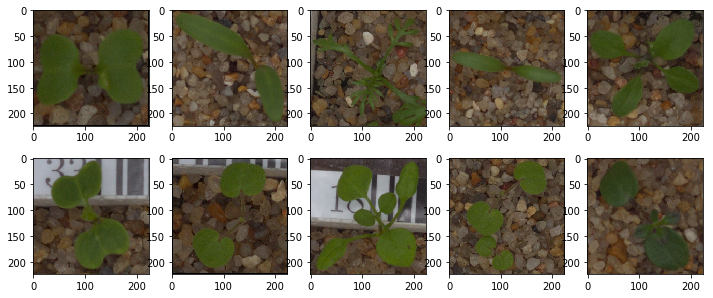

In [13]:
test_imgs = load_images("./data/test/raw/*.png",
                         desired_size=IMG_SIZE,
                         scale_down=True,
                         scale_up=True,
                         write_to="./data/test/resized")

fig = plt.figure(figsize=(12, 5))
for i in range(10):
    sub = fig.add_subplot(2, 5, i + 1)
    rand_i = np.random.randint(0, len(test_imgs))
    sub.imshow(test_imgs[rand_i])

del test_imgs

In [11]:
test_imgs, file_names = load_images("./data/test/resized/*.png", file_names=True)
test_imgs = np.array(test_imgs)

In [12]:
# create a new graph which differs slightly from the previous
inference_graph = tf.Graph()
with inference_graph.as_default():
    # the LRN layer throws an error with too many images at once, so we'll limit to 10,000
    X = tf.placeholder(tf.float32, shape=(len(test_imgs), IMG_SIZE, IMG_SIZE, 3), name="X")
    dropout = tf.constant(0)

    model = AlexNet(X, dropout, num_classes)
    
    predictions = tf.argmax(model.logits, axis=1)
    
    saver = tf.train.Saver()
    
    # restore the model in this graph and see which predications were wrong
    with tf.Session() as sess:
        saver.restore(sess, "./tensorflow-ckpt/model.ckpt")
        test_predictions = sess.run(predictions, feed_dict={X: test_imgs})
        prediction_df = pd.DataFrame(data={"file": file_names, "species": np.array(class_names)[test_predictions]})
        display(prediction_df.head())
        prediction_df.to_csv("./test_predictions.csv", index=False)

INFO:tensorflow:Restoring parameters from ./tensorflow-ckpt/model.ckpt


,file,species
0,e19673dc9.png,Charlock
1,a8c8a1db0.png,Shepherds Purse
2,76dbd1054.png,Scentless Mayweed
3,148bbda66.png,Charlock
4,9c777333d.png,Common Chickweed


In [6]:
model = tf.keras.applications.VGG16(weights=None, classes=12)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss="categorical_crossentropy", metrics=['accuracy'])

# X = tf.keras.applications.resnet50.preprocess_input(train_data_aug)
model.fit(train_data_aug, train_labels_aug,
          batch_size=64,
          epochs=10,
          shuffle=True,
          validation_data=(dev_data, dev_labels))

model.save('resnet50_model.h5')

Train on 32304 samples, validate on 712 samples
Epoch 1/10
32304/32304 [==============================]32304/32304 [==============================] - 345s 11ms/step - loss: 1.9284 - acc: 0.3141 - val_loss: 1.0780 - val_acc: 0.6152

Epoch 2/10
32304/32304 [==============================]32304/32304 [==============================] - 340s 11ms/step - loss: 0.6108 - acc: 0.7872 - val_loss: 0.4507 - val_acc: 0.8399

Epoch 3/10
32304/32304 [==============================]32304/32304 [==============================] - 339s 11ms/step - loss: 0.3019 - acc: 0.8860 - val_loss: 0.3395 - val_acc: 0.8764

Epoch 4/10
32304/32304 [==============================]32304/32304 [==============================] - 338s 10ms/step - loss: 0.2024 - acc: 0.9220 - val_loss: 0.3581 - val_acc: 0.8778

Epoch 5/10
32304/32304 [==============================]32304/32304 [==============================] - 339s 10ms/step - loss: 0.1517 - acc: 0.9390 - val_loss: 0.3047 - val_acc: 0.9101

Epoch 6/10
32304/32304 [========

ImportError: `save_model` requires h5py.

In [14]:
test_predictions = np.argmax(model.predict(test_imgs), axis=1)
prediction_df = pd.DataFrame(data={"file": file_names, "species": np.array(class_names)[test_predictions]})
display(prediction_df.head())
prediction_df.to_csv("./test_predictions.csv", index=False)

ImportError: `save_model` requires h5py.